In [40]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
import os
import math

Build DNN with 20 hidden layers of 100 neurons each. Use He initialization and the ELU activation function

# Build DNN Model

In [8]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32,32,3]))

for _ in range(20):
    model.add(keras.layers.Dense(100,
                                activation='elu',
                                kernel_initializer='he_normal'))

Using Nadam optimizer and early stopping train the network on the CIFAR10 dataset. The datset is composed of 60 000 32 x 32 pixel color images ( 50000 for learning and 10000 for testing) with 10 classes. We use softmax activation output layer. We serch for right learning rate each time we change model hyperparametrs

In [9]:
model.add(keras.layers.Dense(10, activation = 'softmax'))


Use Nadam optimizer with lr of 5e-5. After comparing them in Tensorboard this setup looks better than others

In [10]:
optimizer = keras.optimizers.Nadam(lr= 5e-5)
model.compile(loss = 'sparse_categorical_crossentropy',
             optimizer = optimizer,
             metrics = ['accuracy'])

# Loading CIFAR Dataset

In [12]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.cifar10.load_data()

X_train = X_train_full[5000:]
y_train = y_train_full[5000:]
X_valid = X_train_full[:5000]
y_valid = y_train_full[:5000]

170500096/170498071 [==============================] - 47s 0us/step


Building callbacks we need to train model

In [14]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint('my_cifar10_model.h5', save_best_only=True)
run_index = 1 # Increment every time you train model
run_logdir = os.path.join(os.curdir, 'my_cifar10_logs', 'run){:03d}'.format(run_index))
tensorboad_cb = keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboad_cb]

In [17]:
%load_ext tensorboard
%tensorboard --logdir=./my_cifar10_logs --port=6006

ERROR: Timed out waiting for TensorBoard to start. It may still be running as pid 9664.

In [18]:
model.fit(X_train, y_train, epochs=100, validation_data=(X_valid, y_valid), callbacks=callbacks)

Epoch 1/100
1407/1407 [==============================] - 15s 9ms/step - loss: 9.6474 - accuracy: 0.1398 - val_loss: 2.1317 - val_accuracy: 0.2358
Epoch 2/100
1407/1407 [==============================] - 11s 7ms/step - loss: 2.0824 - accuracy: 0.2412 - val_loss: 2.0609 - val_accuracy: 0.2504
Epoch 3/100
1407/1407 [==============================] - 10s 7ms/step - loss: 1.9496 - accuracy: 0.2886 - val_loss: 1.9954 - val_accuracy: 0.2706
Epoch 4/100
1407/1407 [==============================] - 10s 7ms/step - loss: 1.8545 - accuracy: 0.3231 - val_loss: 1.8433 - val_accuracy: 0.3388
Epoch 5/100
1407/1407 [==============================] - 10s 7ms/step - loss: 1.7888 - accuracy: 0.3455 - val_loss: 1.7957 - val_accuracy: 0.3438
Epoch 6/100
1407/1407 [==============================] - 10s 7ms/step - loss: 1.7450 - accuracy: 0.3654 - val_loss: 1.8352 - val_accuracy: 0.3418
Epoch 7/100
1407/1407 [==============================] - 10s 7ms/step - loss: 1.6999 - accuracy: 0.3828 - val_loss: 1.7427 -

In [19]:
model = keras.models.load_model('my_cifar10_model.h5')
model.evaluate(X_valid,y_valid)

157/157 [==============================] - 1s 2ms/step - loss: 1.4950 - accuracy: 0.4806


[1.4949904680252075, 0.4805999994277954]

The model with lowest validation loss gets about 48 % accuracy on validation set. It took 27 epochs to reach the lowest validation loss, with roughly 8 seconds per epoch on my laptop (without GPU). Let's improve performance with Batch Normalization

BN layers are added after Every Dense layer exept the output layer

In [22]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32,32,3]))
model.add(keras.layers.BatchNormalization())
for _ in range(20):
    model.add(keras.layers.Dense(100, kernel_initializer="he_normal"))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation('elu'))
model.add(keras.layers.Dense(10,activation='softmax'))

optimizer = keras.optimizers.Nadam(lr=5e-4)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("my_cifar10_bn_model.h5", save_best_only=True)
run_index = 1 # increment every time you train the model
run_logdir = os.path.join(os.curdir, "my_cifar10_logs", "run_bn_{:03d}".format(run_index))
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

model.fit(X_train, y_train, epochs=100,
          validation_data=(X_valid, y_valid),
          callbacks=callbacks)

model = keras.models.load_model("my_cifar10_bn_model.h5")
model.evaluate(X_valid, y_valid)

Epoch 1/100
1407/1407 [==============================] - 37s 19ms/step - loss: 1.9809 - accuracy: 0.2925 - val_loss: 1.6815 - val_accuracy: 0.4038
Epoch 2/100
1407/1407 [==============================] - 16s 11ms/step - loss: 1.6830 - accuracy: 0.3982 - val_loss: 1.5858 - val_accuracy: 0.4322
Epoch 3/100
1407/1407 [==============================] - 16s 12ms/step - loss: 1.6160 - accuracy: 0.4265 - val_loss: 1.5552 - val_accuracy: 0.4422
Epoch 4/100
1407/1407 [==============================] - 16s 12ms/step - loss: 1.5573 - accuracy: 0.4445 - val_loss: 1.5626 - val_accuracy: 0.4470
Epoch 5/100
1407/1407 [==============================] - 16s 11ms/step - loss: 1.5114 - accuracy: 0.4614 - val_loss: 1.4501 - val_accuracy: 0.4770
Epoch 6/100
1407/1407 [==============================] - 16s 11ms/step - loss: 1.4684 - accuracy: 0.4755 - val_loss: 1.4182 - val_accuracy: 0.4886
Epoch 7/100
1407/1407 [==============================] - 16s 11ms/step - loss: 1.4341 - accuracy: 0.4892 - val_loss: 1

[1.3191810846328735, 0.5383999943733215]

The model is converging faster than before. The previous model took 27 epochs to reach the lowest validation loss, while the new model achieved that same loss in just 5 epochs and continued to make progress until the 16th epoch. The BN layers stabilized training and allowed us to use a much larger learning rate, so convergence was faster.

BN produce a better model - the final model converged with much better accuray 54% instead of 48 %. It's still not very good but much better than before

BN model converge much faster than without model. Each epoch required more time but overall there are less epochs

# Replacing BN with SELU and other adjustments

Try replacing Batch Normalization with SELU, and make the necessary adjustements to ensure the network self-normalizes (i.e., standardize the input features, use LeCun normal initialization, make sure the DNN contains only a sequence of dense layers, etc.)

In [24]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32,32,3]))
for _ in range(20):
    model.add(keras.layers.Dense(100, kernel_initializer="lecun_normal",activation='selu'))
model.add(keras.layers.Dense(10,activation='softmax'))

optimizer = keras.optimizers.Nadam(lr=7e-4)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("my_cifar10_selu_model.h5", save_best_only=True)
run_index = 1 # increment every time you train the model
run_logdir = os.path.join(os.curdir, "my_cifar10_logs", "run_selu_{:03d}".format(run_index))
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

X_means = X_train.mean(axis=0)
X_stds = X_train.std(axis=0)
X_train_scaled = (X_train - X_means) / X_stds
X_valid_scaled = (X_valid - X_means) / X_stds
X_test_scaled = (X_test - X_means) / X_stds

model.fit(X_train, y_train, epochs=100,
          validation_data=(X_valid, y_valid),
          callbacks=callbacks)

model = keras.models.load_model("my_cifar10_selu_model.h5")
model.evaluate(X_valid, y_valid)

Epoch 1/100
1407/1407 [==============================] - 18s 11ms/step - loss: 2.2782 - accuracy: 0.1818 - val_loss: 2.1038 - val_accuracy: 0.2260
Epoch 2/100
1407/1407 [==============================] - 10s 7ms/step - loss: 1.9494 - accuracy: 0.2750 - val_loss: 2.7958 - val_accuracy: 0.1792
Epoch 3/100
1407/1407 [==============================] - 9s 7ms/step - loss: 1.9050 - accuracy: 0.2924 - val_loss: 1.9841 - val_accuracy: 0.2888
Epoch 4/100
1407/1407 [==============================] - 9s 7ms/step - loss: 1.8518 - accuracy: 0.3184 - val_loss: 2.0070 - val_accuracy: 0.2806
Epoch 5/100
1407/1407 [==============================] - 9s 6ms/step - loss: 1.8163 - accuracy: 0.3322 - val_loss: 1.8091 - val_accuracy: 0.3308
Epoch 6/100
1407/1407 [==============================] - 9s 7ms/step - loss: 1.7824 - accuracy: 0.3441 - val_loss: 1.8567 - val_accuracy: 0.3354
Epoch 7/100
1407/1407 [==============================] - 9s 6ms/step - loss: 1.7640 - accuracy: 0.3504 - val_loss: 1.7226 - val

[1.6363557577133179, 0.40540000796318054]

We get 47.9% accuracy, which is not much better than the original model (47.6%), and not as good as the model using batch normalization (54.0%). However, convergence was almost as fast as with the BN model, plus each epoch took only 7 seconds. So it's by far the fastest model to train so far.

# MC Dropout regularization alpha

In [27]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32,32,3]))
for _ in range(20):
    model.add(keras.layers.Dense(100, kernel_initializer="lecun_normal",activation='selu'))
model.add(keras.layers.AlphaDropout(rate=0.1))
model.add(keras.layers.Dense(10,activation='softmax'))

optimizer = keras.optimizers.Nadam(lr=5e-4)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("my_cifar10_alpha_dropout_model.h5", save_best_only=True)
run_index = 1 # increment every time you train the model
run_logdir = os.path.join(os.curdir, "my_cifar10_logs", "run_alpha_dropout_{:03d}".format(run_index))
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

X_means = X_train.mean(axis=0)
X_stds = X_train.std(axis=0)
X_train_scaled = (X_train - X_means) / X_stds
X_valid_scaled = (X_valid - X_means) / X_stds
X_test_scaled = (X_test - X_means) / X_stds

model.fit(X_train_scaled, y_train, epochs=100,
          validation_data=(X_valid_scaled, y_valid),
          callbacks=callbacks)

model = keras.models.load_model("my_cifar10_alpha_dropout_model.h5")
model.evaluate(X_valid_scaled, y_valid)

Epoch 1/100
1407/1407 [==============================] - 20s 10ms/step - loss: 2.0619 - accuracy: 0.2797 - val_loss: 1.7099 - val_accuracy: 0.3916
Epoch 2/100
1407/1407 [==============================] - 9s 7ms/step - loss: 1.6787 - accuracy: 0.4044 - val_loss: 1.6869 - val_accuracy: 0.4120
Epoch 3/100
1407/1407 [==============================] - 9s 6ms/step - loss: 1.5846 - accuracy: 0.4504 - val_loss: 1.6547 - val_accuracy: 0.4206
Epoch 4/100
1407/1407 [==============================] - 9s 6ms/step - loss: 1.5014 - accuracy: 0.4723 - val_loss: 1.5722 - val_accuracy: 0.4564
Epoch 5/100
1407/1407 [==============================] - 9s 6ms/step - loss: 1.4448 - accuracy: 0.4937 - val_loss: 1.6269 - val_accuracy: 0.4520
Epoch 6/100
1407/1407 [==============================] - 9s 6ms/step - loss: 1.3977 - accuracy: 0.5085 - val_loss: 1.5222 - val_accuracy: 0.4878
Epoch 7/100
1407/1407 [==============================] - 9s 6ms/step - loss: 1.3470 - accuracy: 0.5322 - val_loss: 1.5798 - val_

[1.5082576274871826, 0.501800000667572]

Let's use MC Dropout now. We will need the `MCAlphaDropout` class we used earlier, so let's just copy it here for convenience:

In [28]:
class MCAlphaDropout(keras.layers.AlphaDropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

Now let's create a new model, identical to the one we just trained (with the same weights), but with `MCAlphaDropout` dropout layers instead of `AlphaDropout` layers:

In [29]:
mc_model = keras.models.Sequential([
    MCAlphaDropout(layer.rate) if isinstance(layer, keras.layers.AlphaDropout) else layer
    for layer in model.layers
])

Than Lets add a couple utility functions. The first will run model many times (10 by default) and it will return the mean predicted class probabilities. The second will use these mean probabilities to predict the most likely class for each instance:

In [30]:
def mc_dropout_predict_probas(mc_model, X, n_samples = 10):
    Y_probas = [mc_model.predict(X) for sample in range(n_samples)]
    return np.mean(Y_probas, axis = 0)

def mc_dropout_predict_classes(mc_model, X, n_samples=10):
    Y_probas = mc_dropout_predict_probas(mc_model, X, n_samples)
    return np.argmax(Y_probas, axis=1)

Now let's make predictions for all the instances in the validation set, and compute the accuracy:

In [31]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

y_pred = mc_dropout_predict_classes(mc_model, X_valid_scaled)
accuracy = np.mean(y_pred == y_valid[:, 0])
accuracy

0.4996

We get no accuracy improvement in this case
So the best model is the Batch Normalization model

# 1 Cycle Scheduling

In [32]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32,32,3]))
for _ in range(20):
    model.add(keras.layers.Dense(100, kernel_initializer="lecun_normal",activation='selu'))
model.add(keras.layers.AlphaDropout(rate=0.1))
model.add(keras.layers.Dense(10,activation='softmax'))

optimizer = keras.optimizers.SGD(lr=1e-3)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

In [41]:
K = keras.backend

class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.lr))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.lr, self.model.optimizer.lr * self.factor)

def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=10**-5, max_rate=10):
    init_weights = model.get_weights()
    iterations = math.ceil(len(X) / batch_size) * epochs
    factor = np.exp(np.log(max_rate / min_rate) / iterations)
    init_lr = K.get_value(model.optimizer.lr)
    K.set_value(model.optimizer.lr, min_rate)
    exp_lr = ExponentialLearningRate(factor)
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size,
                        callbacks=[exp_lr])
    K.set_value(model.optimizer.lr, init_lr)
    model.set_weights(init_weights)
    return exp_lr.rates, exp_lr.losses

def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, losses)
    plt.gca().set_xscale('log')
    plt.hlines(min(losses), min(rates), max(rates))
    plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses)) / 2])
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")

In [44]:
class OneCycleScheduler(keras.callbacks.Callback):
    def __init__(self, iterations, max_rate, start_rate=None,
                 last_iterations=None, last_rate=None):
        self.iterations = iterations
        self.max_rate = max_rate
        self.start_rate = start_rate or max_rate / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_rate = last_rate or self.start_rate / 1000
        self.iteration = 0
    def _interpolate(self, iter1, iter2, rate1, rate2):
        return ((rate2 - rate1) * (self.iteration - iter1)
                / (iter2 - iter1) + rate1)
    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            rate = self._interpolate(0, self.half_iteration, self.start_rate, self.max_rate)
        elif self.iteration < 2 * self.half_iteration:
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                     self.max_rate, self.start_rate)
        else:
            rate = self._interpolate(2 * self.half_iteration, self.iterations,
                                     self.start_rate, self.last_rate)
        self.iteration += 1
        K.set_value(self.model.optimizer.lr, rate)

352/352 [==============================] - 5s 10ms/step - loss: nan - accuracy: 0.1248


(9.999999747378752e-06,
 9.615227699279785,
 2.617919683456421,
 3.9362728595733647)

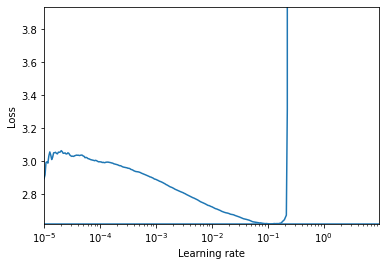

In [42]:
batch_size = 128
rates, losses = find_learning_rate(model, X_train_scaled, y_train, epochs = 1, batch_size=batch_size)
plot_lr_vs_loss(rates, losses)
plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses)) /1.4])

In [43]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(keras.layers.Dense(100,
                                 kernel_initializer="lecun_normal",
                                 activation="selu"))

model.add(keras.layers.AlphaDropout(rate=0.1))
model.add(keras.layers.Dense(10, activation="softmax"))

optimizer = keras.optimizers.SGD(lr=1e-2)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

In [45]:
n_epochs = 15
onecycle = OneCycleScheduler(math.ceil(len(X_train_scaled) / batch_size) * n_epochs, max_rate = 0.05)
history = model.fit(X_train_scaled, y_train, epochs = n_epochs, batch_size= batch_size,
                   validation_data=(X_valid_scaled, y_valid),
                   callbacks=[onecycle])

Epoch 1/15
352/352 [==============================] - 5s 11ms/step - loss: 2.2238 - accuracy: 0.2404 - val_loss: 1.7889 - val_accuracy: 0.3792
Epoch 2/15
352/352 [==============================] - 3s 10ms/step - loss: 1.7876 - accuracy: 0.3695 - val_loss: 1.6318 - val_accuracy: 0.4262
Epoch 3/15
352/352 [==============================] - 3s 10ms/step - loss: 1.6445 - accuracy: 0.4172 - val_loss: 1.6232 - val_accuracy: 0.4252
Epoch 4/15
352/352 [==============================] - 3s 10ms/step - loss: 1.5478 - accuracy: 0.4482 - val_loss: 1.6383 - val_accuracy: 0.4256
Epoch 5/15
352/352 [==============================] - 3s 10ms/step - loss: 1.4876 - accuracy: 0.4742 - val_loss: 1.5952 - val_accuracy: 0.4448
Epoch 6/15
352/352 [==============================] - 3s 10ms/step - loss: 1.4422 - accuracy: 0.4873 - val_loss: 1.5819 - val_accuracy: 0.4522
Epoch 7/15
352/352 [==============================] - 3s 10ms/step - loss: 1.4121 - accuracy: 0.4955 - val_loss: 1.5613 - val_accuracy: 0.4660

One cycle allowed us to train the model in just 15 epochs, each taking only 2 seconds (thanks to the larger batch size). This is several times faster than the fastest model we trained so far. Moreover, we improved the model's performance (from 47.6% to 52.0%). The batch normalized model reaches a slightly better performance (54%), but it's much slower to train.